In [1]:
import numpy as np
import matplotlib.pyplot as plt

import illustris_python as il
import pandas as pd
from matplotlib.gridspec import SubplotSpec


In [2]:
# cd /Users/festabu/TNG50-1/output/groups_099/

/Users/festabu/TNG50-1/output/groups_099


In [2]:
pwd

'/Users/festabu/Desktop/ML_galaxy_size_project/Codes'

In [3]:
basePath_TNG50 = '/Users/festabu/TNG50-1/output'
basePath_TNG100 = '/Users/festabu/TNG100-1/output'

In [4]:
fields2 = ['SubhaloHalfmassRadType','SubhaloMassInRadType', 'SubhaloSFRinRad', 'SubhaloFlag']

# 'SubhaloHalfmassRadType' = Comoving radius containing half of the mass of this Subhalo split by Type (SubhaloMassType).
# 'SubhaloMassInRadType' = Sum of masses of all particles/cells (split by type) within twice the stellar half mass radius.
# 'SubhaloSFRinRad' = Same as SubhaloSFR, but restricted to cells within twice the stellar half mass radius.
# 'SubhaloFlag' = Flag field indicating suitability of this subhalo for certain types of analysis. If zero, this subhalo should generally be excluded, and is not thought to be of cosmological origin. That is, it may have formed within an existing halo, or is possibly a baryonic fragment of a disk or other galactic structure identified by Subfind. If one, this subhalo should be considered a 'galaxy' or 'satellite' of cosmological origin. (Note: always true for centrals). See the data release background for details.
#                 subhalo flag to distinguish between centrals and satellites   

In [5]:
def load_galaxies (basePath, snapshot, fields):
    '''Loads subhalos and defines galaxy mass and galaxy size'''
    
    subhalos = il.groupcat.loadSubhalos(basePath,snapshot,fields=fields)
    
    # define galaxy size
    galaxy_size=subhalos['SubhaloHalfmassRadType'][:,4]
    galaxy_size=galaxy_size/0.7 # divide by h=0.7
    
    # define galaxy mass as only the stellar component
    galaxy_mass=subhalos['SubhaloMassInRadType'][:,4]
    galaxy_mass=(galaxy_mass/0.7)*1e10 # multiply galaxy mass by 1e10 and divide by h=0.7
    
    return subhalos, galaxy_mass, galaxy_size

In [6]:
def function(galaxy_mass, galaxy_size, subhalo_flag, type_of_galaxy):
    '''
    Converts to log10 non-zero size and mass entries for central and satellite galaxies
    
    output: log mass, log size
    
    '''
    #subhalo_flag = subhalos['SubhaloFlag']
    
    if type_of_galaxy == 'central':
        galaxy_mass = galaxy_mass[subhalo_flag]
        galaxy_size = galaxy_size[subhalo_flag]
    
    elif type_of_galaxy == 'satellite':
        galaxy_mass = galaxy_mass[~subhalo_flag]
        galaxy_size = galaxy_size[~subhalo_flag]
        
    else: pass
        
    with np.errstate(divide='ignore'):
        galaxy_mass_log = np.where(galaxy_mass>0, np.log10(galaxy_mass), 0)
        galaxy_size_log = np.where(galaxy_size>0, np.log10(galaxy_size), 0)

    mask_non_zero = galaxy_mass_log>0
    galaxy_mass_log = galaxy_mass_log[mask_non_zero]
    galaxy_size_log = galaxy_size_log[mask_non_zero]

    df_logmass_logsize = pd.DataFrame({'log_size':galaxy_size_log, 
                                       'log_mass':galaxy_mass_log } )
    
    return galaxy_mass_log, galaxy_size_log
    #return df_logmass_logsize


In [7]:
galaxies_TNG50=load_galaxies(basePath_TNG50, 99, fields2)

In [8]:
galaxies_TNG100=load_galaxies(basePath_TNG100, 99, fields2)

In [10]:
# galaxies_TNG100[0]

### Define df for TNG50

In [11]:
# define galaxy mass and size
subhalos_TNG50=galaxies_TNG50[0]

In [12]:
d_TNG50 = {'galaxy_mass_TNG50': galaxies_TNG50[1], 'galaxy_size_TNG50': galaxies_TNG50[2], 'SFR_TNG50': subhalos_TNG50['SubhaloSFRinRad'], 'subhalo_flag_TNG50': subhalos_TNG50['SubhaloFlag'] }

In [13]:
df_TNG50 = pd.DataFrame(data=d_TNG50)

In [14]:
df_TNG50.head(2)

,galaxy_mass_TNG50,galaxy_size_TNG50,SFR_TNG50,subhalo_flag_TNG50
0,3.515673e+12,41.830242,0.155921,True
1,2.643969e+11,8.159544,0.000000,True


In [15]:
df_TNG50.shape

(5688113, 4)

In [17]:
#df_TNG50['galaxy_mass_TNG50']

In [111]:
df_TNG50_mass_filtered = df_TNG50.loc[(df_TNG50.galaxy_mass_TNG50>=10e8) , :] # choose only galaxies that have a mass of logMstar>8

In [114]:
# add a column with the logarithmic value of mass
df_TNG50['log_mass'] = df_TNG50.apply(lambda row: return_log(row, 'galaxy_mass_TNG50'), axis=1)

In [117]:
df_TNG50.shape

(5688113, 5)

In [118]:
df_TNG50_new = df_TNG50.loc[(df_TNG50.log_mass>=8) , :] # choose only galaxies that have a mass of logMstar>8

In [120]:
df_TNG50_new.shape

(7806, 5)

In [112]:
df_TNG50_mass_filtered.shape

(2775, 4)

In [52]:
# add a column that labels galaxy type
df_TNG50_mass_filtered['galaxy_type'] = df_TNG50_mass_filtered.apply(lambda row: 'central' if row['subhalo_flag_TNG50'] else 'satellite', axis=1)

<ipython-input-52-27357dcb4012>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TNG50_mass_filtered['galaxy_type'] = df_TNG50_mass_filtered.apply(lambda row: 'central' if row['subhalo_flag_TNG50'] else 'satellite', axis=1)


In [53]:
df_TNG50_mass_filtered['galaxy_type'].value_counts()

central      2637
satellite     138
Name: galaxy_type, dtype: int64

In [27]:
# function to return the base 10 logarithm of non-zero values
def return_log(row, col):
    if(row[col]!= 0):
        return np.log10(row[col])
    else:
        return 0

In [28]:
# add a column with the logarithmic value of mass
df_TNG50_mass_filtered['log_mass'] = df_TNG50_mass_filtered.apply(lambda row: return_log(row, 'galaxy_mass_TNG50'), axis=1)

<ipython-input-28-b26ac31894b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TNG50_mass_filtered['log_mass'] = df_TNG50_mass_filtered.apply(lambda row: return_log(row, 'galaxy_mass_TNG50'), axis=1)


In [29]:
# add a column with the logarithmic value of size
df_TNG50_mass_filtered['log_size'] = df_TNG50_mass_filtered.apply(lambda row: return_log(row, 'galaxy_size_TNG50'), axis=1)

<ipython-input-29-171ac973aaf6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TNG50_mass_filtered['log_size'] = df_TNG50_mass_filtered.apply(lambda row: return_log(row, 'galaxy_size_TNG50'), axis=1)


In [54]:
df_TNG50_mass_filtered.head(2)

,galaxy_mass_TNG50,galaxy_size_TNG50,SFR_TNG50,subhalo_flag_TNG50,galaxy_type,log_mass,log_size
0,3.515673e+12,41.830242,0.155921,True,central,12.546008,1.621490
1,2.643969e+11,8.159544,0.000000,True,central,11.422256,0.911666


In [17]:
# df_TNG50.loc[(df_TNG50.galaxy_mass_TNG50>10e8) &
#              (df_TNG50.SFR_TNG50 >0) , :]

### Define df for TNG100

In [31]:
# define galaxy mass and size
subhalos_TNG100=galaxies_TNG100[0]

In [32]:
d_TNG100 = {'galaxy_mass_TNG100': galaxies_TNG100[1], 'galaxy_size_TNG100': galaxies_TNG100[2], 'SFR_TNG100': subhalos_TNG100['SubhaloSFRinRad'], 'subhalo_flag_TNG100': subhalos_TNG100['SubhaloFlag'] }

In [33]:
df_TNG100 = pd.DataFrame(data=d_TNG100)

In [34]:
df_TNG100.head(2)

,galaxy_mass_TNG100,galaxy_size_TNG100,SFR_TNG100,subhalo_flag_TNG100
0,2.340489e+12,67.697227,0.195825,True
1,3.675859e+11,24.303402,0.088085,True


In [36]:
df_TNG100.shape

(4371211, 4)

In [37]:
df_TNG100_mass_filtered = df_TNG100.loc[(df_TNG100.galaxy_mass_TNG100>10e8) , :] # choose only galaxies that have a mass of logMstar>8

In [38]:
df_TNG100_mass_filtered.shape

(19799, 4)

In [44]:
# add a column that labels galaxy type
df_TNG100_mass_filtered['galaxy_type'] = df_TNG100_mass_filtered.apply(lambda row: 'central' if row['subhalo_flag_TNG100']==True else 'satellite', axis=1)

<ipython-input-44-759c990019ee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TNG100_mass_filtered['galaxy_type'] = df_TNG100_mass_filtered.apply(lambda row: 'central' if row['subhalo_flag_TNG100']==True else 'satellite', axis=1)


In [48]:
df_TNG100_mass_filtered['galaxy_type'].value_counts()

central      18559
satellite     1240
Name: galaxy_type, dtype: int64

In [55]:
# add a column with the logarithmic value of mass
df_TNG100_mass_filtered['log_mass'] = df_TNG100_mass_filtered.apply(lambda row: return_log(row, 'galaxy_mass_TNG100'), axis=1)

<ipython-input-55-7028b7b9e8b2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TNG100_mass_filtered['log_mass'] = df_TNG100_mass_filtered.apply(lambda row: return_log(row, 'galaxy_mass_TNG100'), axis=1)


In [56]:
# add a column with the logarithmic value of size
df_TNG100_mass_filtered['log_size'] = df_TNG100_mass_filtered.apply(lambda row: return_log(row, 'galaxy_size_TNG100'), axis=1)

<ipython-input-56-be3c51d4cab1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_TNG100_mass_filtered['log_size'] = df_TNG100_mass_filtered.apply(lambda row: return_log(row, 'galaxy_size_TNG100'), axis=1)


In [104]:
df_TNG100_mass_filtered.head(2)

,galaxy_mass_TNG100,galaxy_size_TNG100,SFR_TNG100,subhalo_flag_TNG100,galaxy_type,log_mass,log_size
0,2.340489e+12,67.697227,0.195825,True,central,12.369307,1.830571
1,3.675859e+11,24.303402,0.088085,True,central,11.565359,1.385667


In [101]:
def plot_df_mass_size_sfr(df, sfr, galaxy_type = 'central'):
    
    sub_df = df.loc[df["galaxy_type"] == galaxy_type, ["log_mass","log_size", sfr]]
    plt.scatter(sub_df["log_mass"], sub_df["log_size"], c = np.log10(sub_df[sfr]+0.01), s=50, marker='o')
    plt.xlabel('Total Mass [$M_\odot$]')
    plt.ylabel('Galaxy Size [kpc]($ Log_{10} $)')
    plt.legend('Star Formation Rate \n [$M_\odot / yr$]')
    plt.colorbar()
    plt.show()

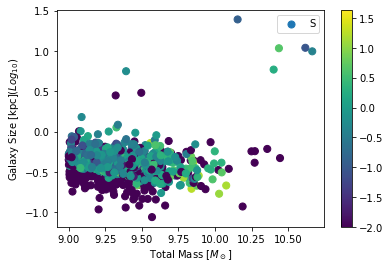

In [102]:
plot_df_mass_size_sfr(df_TNG100_mass_filtered, 'SFR_TNG100', galaxy_type= 'satellite')

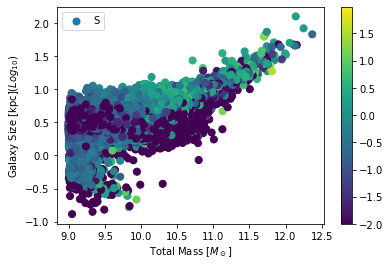

In [103]:
plot_df_mass_size_sfr(df_TNG100_mass_filtered,'SFR_TNG100', galaxy_type= 'central')

### Mass vs SFR Plot - Example from tng-project.org

Text(0, 0.5, 'Star Formation Rate [$M_\\odot / yr$]')

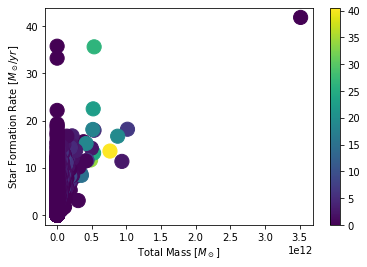

In [28]:
#fields = ['SubhaloMass','SubhaloSFRinRad']
#subhalos = il.groupcat.loadSubhalos(basePath,99,fields=fields)
#mass_msun = subhalos['SubhaloMass'] * 1e10 / 0.704
#sfr=subhalos['SubhaloSFRinRad']
#plt.scatter(galaxy_mass,galaxy_size, c=sfr)
#plt.xscale('log')
#plt.yscale('log')
fig, ax = plt.subplots()
scat = ax.scatter(galaxy_mass,galaxy_size, c=sfr, s=200, marker='o')
fig.colorbar(scat)
plt.xlabel('Total Mass [$M_\odot$]')
plt.ylabel('Star Formation Rate [$M_\odot / yr$]')

### Scatter plot

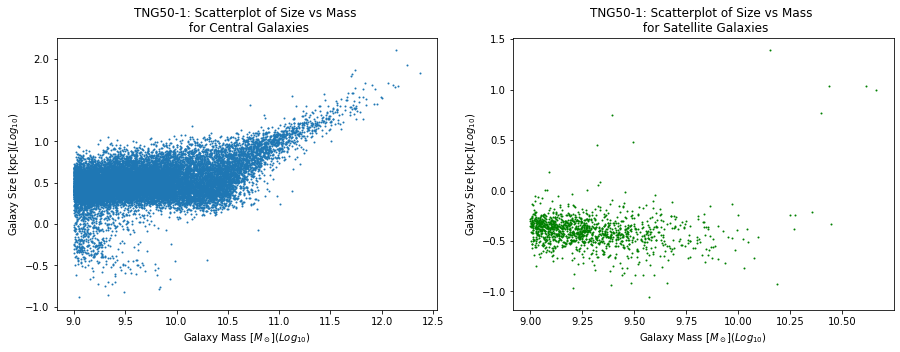

In [110]:
# plt.plot(galaxy_mass,galaxy_size, '.', markersize=2)
# plt.xscale('log')
# plt.yscale('log')
# plt.ylabel('Galaxy Size [kpc]')
# plt.xlabel('Galaxy Mass [$ M_\odot $]')
# #plt.savefig("Mass_vs_Size_updated_v2.jpeg", dpi=500)
# plt.show()

fig3,[ax1, ax2]=plt.subplots(nrows=1,ncols=2,figsize=(15,5))

ax1.plot(central_galaxies_mass_TNG100, central_galaxies_size_TNG100, '.', markersize=2)
ax1.set_title('TNG50-1: Scatterplot of Size vs Mass \n for Central Galaxies')
ax1.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax1.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')

ax2.plot(satellite_galaxies_mass_TNG100, satellite_galaxies_size_TNG100, '.', markersize=2, color='g')
ax2.set_title('TNG50-1: Scatterplot of Size vs Mass \n for Satellite Galaxies')
ax2.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax2.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
plt.show()

#plt.savefig("TNG501_central_satellite_scatterplot.jpeg", dpi=500)



#### Plot the 1D histograms

#### Mass and Size

In [108]:
central_TNG50 = df_TNG50_mass_filtered.loc[df_TNG50_mass_filtered["galaxy_type"] == 'central', ["log_mass","log_size", 'SFR_TNG50']]
central_galaxies_mass_TNG50=central_TNG50["log_mass"]
central_galaxies_size_TNG50=central_TNG50["log_size"]

satellite_TNG50 = df_TNG50_mass_filtered.loc[df_TNG50_mass_filtered["galaxy_type"] == 'satellite', ["log_mass","log_size", 'SFR_TNG50']]
satellite_galaxies_mass_TNG50=satellite_TNG50["log_mass"]
satellite_galaxies_size_TNG50=satellite_TNG50["log_size"]

central_TNG100 = df_TNG100_mass_filtered.loc[df_TNG100_mass_filtered["galaxy_type"] == 'central', ["log_mass","log_size", 'SFR_TNG100']]
central_galaxies_mass_TNG100=central_TNG100["log_mass"]
central_galaxies_size_TNG100=central_TNG100["log_size"]

satellite_TNG100 = df_TNG100_mass_filtered.loc[df_TNG100_mass_filtered["galaxy_type"] == 'satellite', ["log_mass","log_size", 'SFR_TNG100']]
satellite_galaxies_mass_TNG100=satellite_TNG100["log_mass"]
satellite_galaxies_size_TNG100=satellite_TNG100["log_size"]

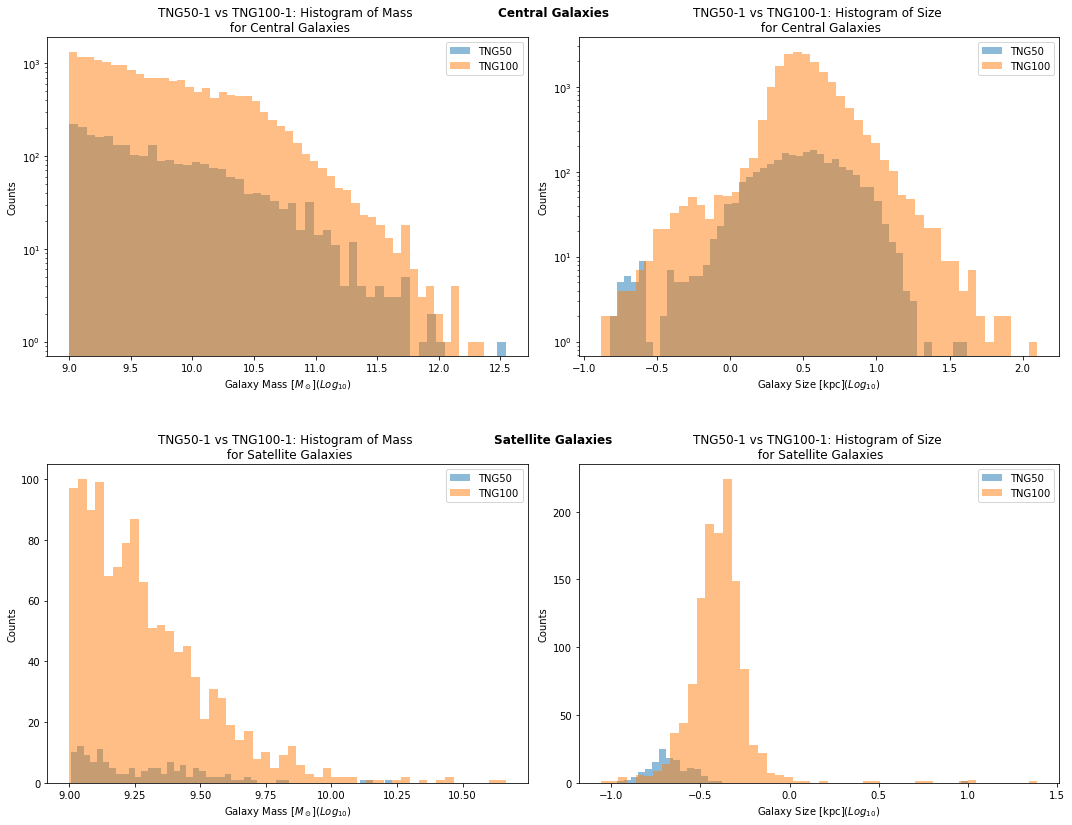

In [109]:
fig,[(ax1, ax2), (ax3, ax4)]=plt.subplots(nrows=2,ncols=2,figsize=(15,12))

ax1.hist(central_galaxies_mass_TNG50, bins=50, log=True, alpha=0.5, label='TNG50')
ax1.hist(central_galaxies_mass_TNG100, bins=50, log=True, alpha=0.5, label='TNG100')
ax1.set_title('TNG50-1 vs TNG100-1: Histogram of Mass \n for Central Galaxies')
ax1.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax1.set_ylabel('Counts')
ax1.legend(loc='upper right')

ax2.hist(central_galaxies_size_TNG50,bins=50, log=True, alpha=0.5, label='TNG50')
ax2.hist(central_galaxies_size_TNG100, bins=50, log=True, alpha=0.5, label='TNG100')
ax2.set_title('TNG50-1 vs TNG100-1: Histogram of Size \n for Central Galaxies')
ax2.set_xlabel('Galaxy Size [kpc]($ Log_{10} $)')
ax2.set_ylabel('Counts')
ax2.legend(loc='upper right')

ax3.hist(satellite_galaxies_mass_TNG50, bins=50, alpha=0.5, label='TNG50')
ax3.hist(satellite_galaxies_mass_TNG100, bins=50, alpha=0.5, label='TNG100')
ax3.set_title('TNG50-1 vs TNG100-1: Histogram of Mass \n for Satellite Galaxies')
ax3.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax3.set_ylabel('Counts')
ax3.legend(loc='upper right')

ax4.hist(satellite_galaxies_size_TNG50, bins=50, alpha=0.5, label='TNG50')
ax4.hist(satellite_galaxies_size_TNG100, bins=50, alpha=0.5, label='TNG100')
ax4.set_title('TNG50-1 vs TNG100-1: Histogram of Size \n for Satellite Galaxies')
ax4.set_xlabel('Galaxy Size [kpc]($ Log_{10} $)')
ax4.set_ylabel('Counts')
ax4.legend(loc='upper right')

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')
    
grid = plt.GridSpec(2, 2)
create_subtitle(fig, grid[0, ::], 'Central Galaxies')
create_subtitle(fig, grid[1, ::], 'Satellite Galaxies')
fig.tight_layout()
#plt.savefig("TNG501_central_Hist1D.jpeg", dpi=500)
plt.show()

#### Mass and Size Density (divide by the volume of the simulation)

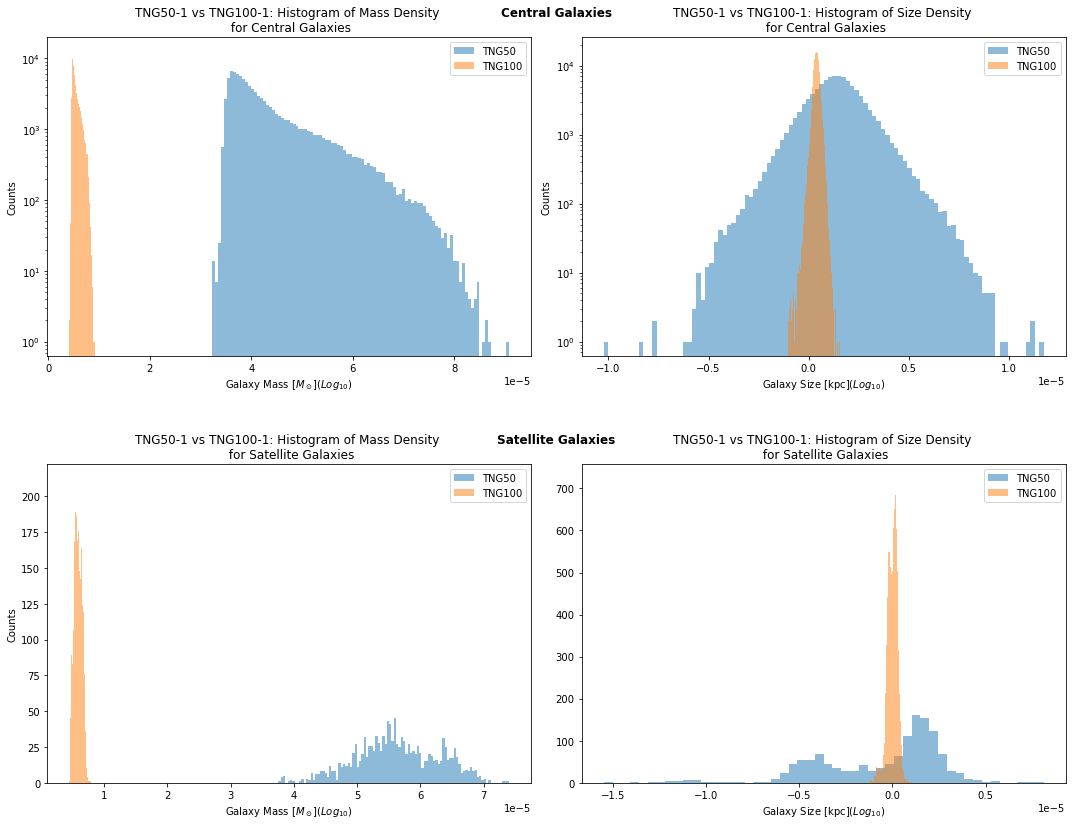

In [114]:
fig3,[(ax1, ax2), (ax3, ax4)]=plt.subplots(nrows=2,ncols=2,figsize=(15,12))

ax1.hist(central_galaxies_mass_TNG50/((51.7)**3), bins=100, log=True, alpha=0.5, label='TNG50')
ax1.hist(central_galaxies_mass_TNG100/((110.7)**3), bins=100, log=True, alpha=0.5, label='TNG100')
ax1.set_title('TNG50-1 vs TNG100-1: Histogram of Mass Density \n for Central Galaxies')
ax1.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax1.set_ylabel('Counts')
ax1.legend(loc='upper right')

ax2.hist(central_galaxies_size_TNG50/((51.7)**3),bins=100, log=True, alpha=0.5, label='TNG50')
ax2.hist(central_galaxies_size_TNG100/((110.7)**3), bins=100, log=True, alpha=0.5, label='TNG100')
ax2.set_title('TNG50-1 vs TNG100-1: Histogram of Size Density \n for Central Galaxies')
ax2.set_xlabel('Galaxy Size [kpc]($ Log_{10} $)')
ax2.set_ylabel('Counts')
ax2.legend(loc='upper right')

ax3.hist(satellite_galaxies_mass_TNG50/((51.7)**3), bins=100, alpha=0.5, label='TNG50')
ax3.hist(satellite_galaxies_mass_TNG100/((110.7)**3), bins=100, alpha=0.5, label='TNG100')
ax3.set_title('TNG50-1 vs TNG100-1: Histogram of Mass Density \n for Satellite Galaxies')
ax3.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax3.set_ylabel('Counts')
ax3.legend(loc='upper right')

ax4.hist(satellite_galaxies_size_TNG50/((51.7)**3), bins=50, alpha=0.5, label='TNG50')
ax4.hist(satellite_galaxies_size_TNG100/((110.7)**3), bins=50, alpha=0.5, label='TNG100')
ax4.set_title('TNG50-1 vs TNG100-1: Histogram of Size Density \n for Satellite Galaxies')
ax4.set_xlabel('Galaxy Size [kpc]($ Log_{10} $)')
ax4.legend(loc='upper right')

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')
    
grid3 = plt.GridSpec(2, 2) #plt.GridSpec(rows, columns)
create_subtitle(fig3, grid3[0, ::], 'Central Galaxies')
create_subtitle(fig3, grid3[1, ::], 'Satellite Galaxies')
fig3.tight_layout()
#plt.savefig("TNG501_central_Hist1D.jpeg", dpi=500)

plt.show()

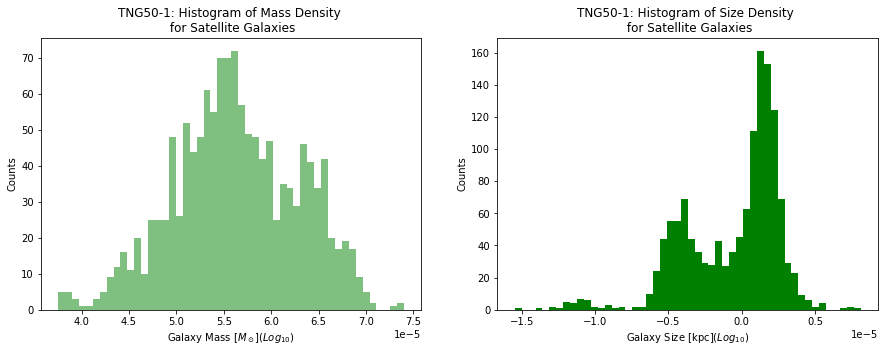

In [48]:
fig4,[ax1, ax2]=plt.subplots(nrows=1,ncols=2,figsize=(15,5))

ax1.hist(satellite_galaxies_mass/((51.7)**3), facecolor='g', bins=50, alpha=0.5)
ax1.set_title('TNG50-1: Histogram of Mass Density \n for Satellite Galaxies')
ax1.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax1.set_ylabel('Counts')

ax2.hist(satellite_galaxies_size/((51.7)**3), facecolor='g', bins=50)
ax2.set_title('TNG50-1: Histogram of Size Density \n for Satellite Galaxies')
ax2.set_xlabel('Galaxy Size [kpc]($ Log_{10} $)')
ax2.set_ylabel('Counts')

#plt.savefig("TNG501_satellite_Hist1D.jpeg", dpi=500)
plt.show()



### Plot the 2D histograms

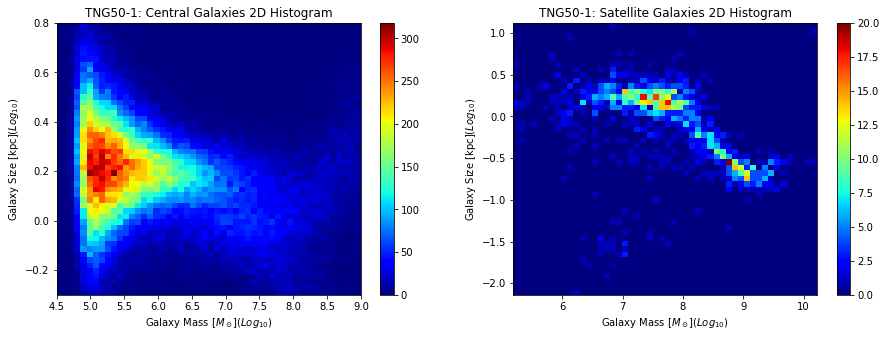

In [103]:
# Figure using the Matplotlib hist2d
import matplotlib.cm as cm
import matplotlib.colors as norm

fig4,[ax1, ax2]=plt.subplots(nrows=1,ncols=2,figsize=(15,5))

im1 = ax1.hist2d(central_galaxies_mass, central_galaxies_size, cmap = plt.cm.jet, bins=50, range=[[4.5,9],[-0.3,0.8]])
ax1.set_title('TNG50-1: Central Galaxies 2D Histogram')
ax1.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax1.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
fig4.colorbar(im1[3], ax=ax1)



im2 = ax2.hist2d(satellite_galaxies_mass, satellite_galaxies_size, cmap = plt.cm.jet, bins=50)
ax2.set_title('TNG50-1: Satellite Galaxies 2D Histogram')
ax2.set_xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
ax2.set_ylabel('Galaxy Size [kpc]($ Log_{10} $)')
fig4.colorbar(im2[3], ax=ax2)



#plt.savefig("TNG501_central_satellite_Hist2D.jpeg", dpi=500)
plt.show()


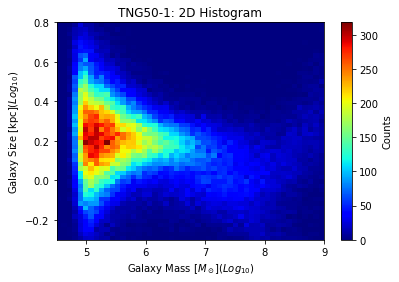

In [33]:
# Figure using the Matplotlib hist2d where histogram range is defined

plt.hist2d(central_galaxies_mass, central_galaxies_size, cmap = plt.cm.jet, bins=50,  range=[[4.5,9],[-0.3,0.8]]  )
plt.title('TNG50-1: 2D Histogram')
plt.ylabel('Galaxy Size [kpc]($ Log_{10} $)')
plt.xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
cbar2 = plt.colorbar()
cbar2.ax.set_ylabel('Counts')
#plt.savefig("TNG501_GalaxyStellarMass_vs_Size_Hist2D_v2.jpeg", dpi=500)
plt.show()

### Histogram 2D and Scatter Plot overlap

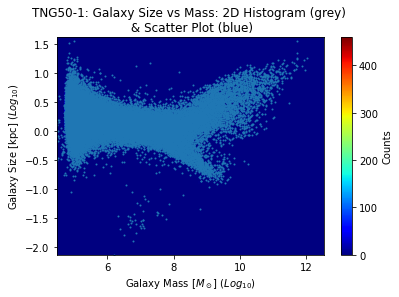

In [50]:
fig2, ax =plt.subplots()
#axis=fig2.add_subplot()
#hist2dplot(ax, galaxy_mass_log, galaxy_size_log, fill=True)
plt.hist2d(galaxy_mass_log, galaxy_size_log, cmap = plt.cm.jet, bins=100)
cbar2 = plt.colorbar()
cbar2.ax.set_ylabel('Counts')
plt.title('TNG50-1: Galaxy Size vs Mass: 2D Histogram (grey) \n & Scatter Plot (blue)')
plt.plot(galaxy_mass_log,galaxy_size_log, '.', markersize=2)
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('Galaxy Size [kpc] ($ Log_{10} $)')
plt.xlabel('Galaxy Mass [$ M_\odot $] ($ Log_{10} $)')
#plt.savefig("TNG501_GalaxyStellarMass_vs_Size_hist2d_and_scatterplot.jpeg", dpi=500)
plt.show()

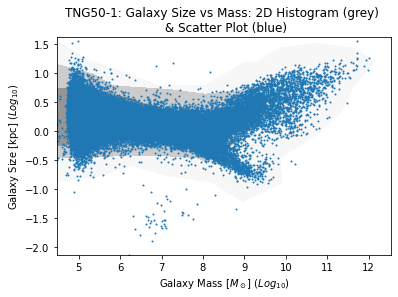

In [51]:
fig2, ax =plt.subplots()
#axis=fig2.add_subplot()
hist2dplot(ax, galaxy_mass_log, galaxy_size_log, fill=True)
plt.title('TNG50-1: Galaxy Size vs Mass: 2D Histogram (grey) \n & Scatter Plot (blue)')
plt.plot(galaxy_mass_log,galaxy_size_log, '.', markersize=2)
#plt.xscale('log')
#plt.yscale('log')
plt.ylabel('Galaxy Size [kpc] ($ Log_{10} $)')
plt.xlabel('Galaxy Mass [$ M_\odot $] ($ Log_{10} $)')
#plt.savefig("TNG501_GalaxyStellarMass_vs_Size_hist2d_and_scatterplot.jpeg", dpi=500)
plt.show()

### 2D Histogram function with contours

In [ ]:
def hist2dplot(axis,x,y,fill=True,**kwargs):
    
    h,xed,yed=np.histogram2d(x,y)
    
    
    h=np.transpose(h)
    total=h.sum()
    h=h/total
    hflat=np.sort(np.reshape(h,-1)) #makes 1D and sorted 
    csum=np.cumsum(hflat)
    values=1.0-np.array([0.9973,0.9545,0.6827,0.0])
    
    levels=[]
    
    for val in values:
        idx = (np.abs(csum - val)).argmin()
        levels.append(hflat[idx])

    if fill:
        #colors=['#f7f7f7','#cccccc','#969696','#525252'] #gray
        colors=['#ffffcc','#c2e699','#78c679','#238443'] #green 
        axis.contourf(h,levels,colors=colors,extent=[xed[0],xed[-1],yed[0],yed[-1]])
    else:
        colors=['#fdcc8a','#fc8d59','#d7301f']
        axis.contour(h,levels,colors=colors,extent=[xed[0],xed[-1],yed[0],yed[-1]])
    
    

In [ ]:
# Figure using the 2D Histogram function

fig2, ax =plt.subplots()
#axis=fig2.add_subplot()
hist2dplot(ax, central_galaxies_mass_TNG100, central_galaxies_size_TNG100, fill=True, bins=1000)
hist2dplot(ax, central_galaxies_mass_TNG50, central_galaxies_size_TNG50, fill=False, bins=1000)
plt.title('TNG100-1: 2D Histogram with hist2d code function')
plt.ylabel('Galaxy Size [kpc]')
plt.xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
#plt.savefig("TNG501_GalaxyStellarMass_vs_Size_hist2Dplot_v1.jpeg", dpi=500)

In [ ]:
# Figure using the 2D Histogram function where histogram range is defined

fig2, ax =plt.subplots()
#axis=fig2.add_subplot()
hist2dplot(ax, galaxy_mass_log, galaxy_size_log, fill=True, bins=10, range=[[8,11],[0.4,1.4]])
plt.title('TNG50-1: 2D Histogram with hist2d code function')
plt.ylabel('Galaxy Size [kpc]')
plt.xlabel('Galaxy Mass [$ M_\odot $]($ Log_{10} $)')
#plt.savefig("TNG501_GalaxyStellarMass_vs_Size_hist2Dplot_v2.jpeg", dpi=500)